# Analyzing Bechdel test results using TMDB data : 
# gender of the main character on the poster

We push forward the task initiated in `4. Analyzing gender representation in posters with Computer Vision` and investigate to what extent the gender of the main character on the movie posters depend on the Bechdel ratings.

## Import packages

In [97]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
# For developers who want to use the latest development version or the library locally
# Use poetry to install dependencies
import sys
sys.path.append("../") # Or change to the folder to the direction of the working directory

%load_ext autoreload
%autoreload 2

import bechdelai

## Import matched Bechdeltest / TMDB data from csv files
The fetching and matching steps have already been done in the tutorial `BechdelAI tutorial #3 - Analyzing Bechdel test results using TMDB data`. Here, we import data from json files created at the end of this notebook (actually in the original version of this tutorial, csv files were created but this raises some issues I cannot get rid of easily, e.g. lists are transformed to strings. That's why I switched to the json format). 

In [3]:
path = "Bechdel_TMDB_data/"       # Enter the path to the csv files
metadata = pd.read_json(path + "bechdel_movies_metadata.json")

pd.set_option('display.max_columns', None)
metadata.head(2)

adult                     backdrop_path belongs_to_collection  budget  \
0  False  /6vYffq6NoneNmNPp6IsobnnlrHS.jpg                  None       0   
1  False                              None                  None       0   

                                genres homepage      id     imdb_id  \
0  [{'id': 99, 'name': 'Documentary'}]           315946   tt3155794   
1    [{'id': 16, 'name': 'Animation'}]           766094  tt14495706   

  original_language     original_title  \
0                fr   Passage de Venus   
1                xx  La Rosace Magique   

                                            overview  popularity  \
0  Photo sequence of the rare transit of Venus ov...       4.509   
1  Praxinoscope strip of a shifting rosette. Seri...       1.011   

                        poster_path production_companies  \
0   /XWPDZzK7N2WQcejI8W96IxZEeP.jpg                   []   
1  /5zeVMAp3R4QHGarSc4Bf3B1uBY2.jpg                   []   

                       production_countries release_date  revenue  runtime  \
0  [{'iso_3166_1': 'FR', 'name': 'France'}]   1874-12-09        0        1   
1  [{'iso_3166_1': 'FR', 'name': 'France'}]   1878-05-07        0        1   

                                    spoken_languages    status tagline  \
0  [{'english_name': 'No Language', 'iso_639_1': ...  Released           
1  [{'english_name': 'No Language', 'iso_639_1': ...  Released           

               title  video  vote_average  vote_count  bechdel_rating  count  
0   Passage of Venus  False           6.2          80               0      1  
1  The Magic Rosette  False           6.0          13               0      1

## Basic pre-processing

Add a column for the release year

In [4]:
metadata['release_date'] = pd.to_datetime(metadata['release_date'])
metadata['release_year'] = metadata['release_date'].dt.year
metadata.head(2)

adult                     backdrop_path belongs_to_collection  budget  \
0  False  /6vYffq6NoneNmNPp6IsobnnlrHS.jpg                  None       0   
1  False                              None                  None       0   

                                genres homepage      id     imdb_id  \
0  [{'id': 99, 'name': 'Documentary'}]           315946   tt3155794   
1    [{'id': 16, 'name': 'Animation'}]           766094  tt14495706   

  original_language     original_title  \
0                fr   Passage de Venus   
1                xx  La Rosace Magique   

                                            overview  popularity  \
0  Photo sequence of the rare transit of Venus ov...       4.509   
1  Praxinoscope strip of a shifting rosette. Seri...       1.011   

                        poster_path production_companies  \
0   /XWPDZzK7N2WQcejI8W96IxZEeP.jpg                   []   
1  /5zeVMAp3R4QHGarSc4Bf3B1uBY2.jpg                   []   

                       production_countries release_date  revenue  runtime  \
0  [{'iso_3166_1': 'FR', 'name': 'France'}]   1874-12-09        0        1   
1  [{'iso_3166_1': 'FR', 'name': 'France'}]   1878-05-07        0        1   

                                    spoken_languages    status tagline  \
0  [{'english_name': 'No Language', 'iso_639_1': ...  Released           
1  [{'english_name': 'No Language', 'iso_639_1': ...  Released           

               title  video  vote_average  vote_count  bechdel_rating  count  \
0   Passage of Venus  False           6.2          80               0      1   
1  The Magic Rosette  False           6.0          13               0      1   

   release_year  
0        1874.0  
1        1878.0

Keep only relevant features

In [5]:
metadata = metadata[['genres', 'id', 'original_title', 'release_year', 'bechdel_rating']]

# Explode the graph by the list of genres and get genre name
def get_name(dic):
    if isinstance(dic, dict):
        return dic['name']
    else:
        return dic
    
metadata = metadata.explode("genres")
metadata['genres'] = metadata['genres'].apply(get_name) 



In [6]:
metadata.head()

genres      id              original_title  release_year  \
0  Documentary  315946            Passage de Venus        1874.0   
1    Animation  766094           La Rosace Magique        1878.0   
2    Animation  194079  Sallie Gardner at a Gallop        1878.0   
2  Documentary  194079  Sallie Gardner at a Gallop        1878.0   
3    Animation  751212           Le Singe Musicien        1878.0   

   bechdel_rating  
0               0  
1               0  
2               0  
2               0  
3               0

## Choose movies

Choose movies released in 2022 that are not animation movies

In [8]:
metadata_select = metadata[metadata['release_year']==2022]
animation_ids = metadata_select[metadata_select['genres']=='Animation']['id'].tolist()
metadata_select = metadata_select[-metadata_select['id'].isin(animation_ids)]
# Drop the column 'genres', we don't need it anymore
metadata_select = metadata_select.drop("genres", axis = 1)
metadata_select = metadata_select.drop_duplicates()

In [9]:
metadata_select.isna().sum(axis = 0)

id                0
original_title    0
release_year      0
bechdel_rating    0
dtype: int64

## Download all posters 

To be run only once (of course no need to re-download the posters if already done)

In [11]:
poster_folder = "posters_2022/"     # choose where to store the posters

In [12]:
from bechdelai.data.tmdb import TMDB

In [ ]:
'''
movie_select_ids = metadata_select['id'].tolist()

# tmdb = TMDB(api_key = "XXXXXXX") #replace here with your API_KEY
# If you don't pass an API key, the TMDB class will look for one TMDB_API_KEY in an .env file
# So if you have a .env file configured, you can instantiate the TMDB client with the simple function
tmdb = TMDB()
tmdb.download_all_posters(movie_select_ids, poster_folder)
'''

## Poster analysis

In [13]:
from PIL import Image

In [14]:
from bechdelai.image.face_detection import FacesDetector
from bechdelai.image.gender_detection import GenderDetector
from bechdelai.image.clip import CLIP

In [15]:
fd = FacesDetector()
gd = GenderDetector()

Loading CLIP model


In [16]:
# Function that returns all infos extracted by poster analysis
# for the posters with ids in the list movie_ids and with poster images stored in poster_folder
def posters_analysis(movie_ids, poster_folder = "posters_2022/"):
    all_probas = pd.DataFrame()
    for movie_id in tqdm(movie_ids):    # loop on movies
        # open the poster
        poster_path = poster_folder + str(movie_id) + ".png"
        poster = Image.open(poster_path) 
        # detect the faces
        rois, faces = fd.detect(np.array(poster), method = "retinaface", padding = 20)
        # close the poster
        poster.close()
        # predict the genders
        try:   # if faces can be detected
            probas = gd.predict(faces)
            # complete the dataframe `probas` containing results for one movie
            probas['id'] = movie_id
            probas['rois'] = pd.Series([{'face_'+str(idx+1): rois['face_'+str(idx+1)]} for idx in probas.index.tolist()])
        except:  #if faces cannot be detected
            column_names = ['man', 'woman', 'diff', 'gender', 'area', 'area_percentage_relative', 'id', 'rois']
            probas = pd.DataFrame(columns = column_names, index=[0])   # empty dataframe
            probas['id'] = movie_id
            probas['gender'] = 'no face'
        # update the dataframe `all_probas` containing results for all movies
        all_probas = pd.concat([all_probas, probas], axis = 0)
       
        
    return all_probas


# Function that adds to the input dataframe containing only metadata infos
# some columns containing the gender of the MAIN character on the movie poster (and other poster analysis infos) 
def add_poster_analysis(dataframe, poster_folder = "posters_2022/"):
    # Get movie ids
    movie_ids = dataframe['id'].tolist()
    # Perform the complete poster analysis
    all_probas_df = posters_analysis(movie_ids, poster_folder = poster_folder)
    #Merge results with the dataframe
    dataframe = dataframe.merge(all_probas_df, on = "id", how = 'left')
    # For each movie, keep only infos about the main character on the poster 
    # (i.e the character with the largest face area)
    dataframe = (dataframe
                 .sort_values(by = ['id', 'area'], ascending = False)
                 .groupby('id')
                 .head(1)
                )
    
    return all_probas_df, dataframe



#### Optional : show all infos extracted from poster analysis on a few posters
Note that the movie with id=788921 has no detected faces

In [ ]:
# Run poster analysis
movie_ids = [579974, 619730, 788921]
all_probas = posters_analysis(movie_ids)

# Show 
pd.set_option('display.max_columns', None)
display(all_probas)

#### Run poster analysis for all selected movies

In [17]:
_, metadata_select = add_poster_analysis(metadata_select, poster_folder = poster_folder)

100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [05:50<00:00,  2.70s/it]


Save results

In [18]:
metadata_select.to_pickle("metadata_select_2022_noanim.pkl")

## Show posters

Load results

In [19]:
metadata_select = pd.read_pickle("metadata_select_2022_noanim.pkl")

In [20]:
metadata_select.isna().sum(axis = 0)

id                           0
original_title               0
release_year                 0
bechdel_rating               0
man                         21
woman                       21
diff                        21
gender                       0
area                        21
area_percentage_relative    21
rois                        21
dtype: int64

Movies for which no faces has been detected on the poster

In [21]:
metadata_select[metadata_select.isna().any(axis = 1)]

id                original_title  release_year  bechdel_rating  man  \
328  928344  Weird: The Al Yankovic Story        2022.0               1  NaN   
247  852046                        Athena        2022.0               2  NaN   
246  848685                     As bestas        2022.0               3  NaN   
358  843932                         Nanny        2022.0               3  NaN   
199  838330                      Not Okay        2022.0               3  NaN   
243  830788                The Invitation        2022.0               3  NaN   
172  819309                     Emergency        2022.0               3  NaN   
273  817758                           TÁR        2022.0               3  NaN   
322  791333            El cuarto pasajero        2022.0               0  NaN   
6    788921        Everything Will Change        2022.0               0  NaN   
125  780609                           Men        2022.0               3  NaN   
189  766507                          Prey        2022.0               3  NaN   
194  762504                          Nope        2022.0               1  NaN   
155  760104                             X        2022.0               3  NaN   
378  736732                           브로커        2022.0               3  NaN   
195  698948                Thirteen Lives        2022.0               0  NaN   
53   632727       Texas Chainsaw Massacre        2022.0               3  NaN   
209  630720                 Occhiali neri        2022.0               3  NaN   
9    614939                          Bros        2022.0               3  NaN   
196  520023          Bodies Bodies Bodies        2022.0               3  NaN   
242  301502                        Blonde        2022.0               2  NaN   

     woman  diff   gender area  area_percentage_relative rois  
328    NaN   NaN  no face  NaN                       NaN  NaN  
247    NaN   NaN  no face  NaN                       NaN  NaN  
246    NaN   NaN  no face  NaN                       NaN  NaN  
358    NaN   NaN  no face  NaN                       NaN  NaN  
199    NaN   NaN  no face  NaN                       NaN  NaN  
243    NaN   NaN  no face  NaN                       NaN  NaN  
172    NaN   NaN  no face  NaN                       NaN  NaN  
273    NaN   NaN  no face  NaN                       NaN  NaN  
322    NaN   NaN  no face  NaN                       NaN  NaN  
6      NaN   NaN  no face  NaN                       NaN  NaN  
125    NaN   NaN  no face  NaN                       NaN  NaN  
189    NaN   NaN  no face  NaN                       NaN  NaN  
194    NaN   NaN  no face  NaN                       NaN  NaN  
155    NaN   NaN  no face  NaN                       NaN  NaN  
378    NaN   NaN  no face  NaN                       NaN  NaN  
195    NaN   NaN  no face  NaN                       NaN  NaN  
53     NaN   NaN  no face  NaN                       NaN  NaN  
209    NaN   NaN  no face  NaN                       NaN  NaN  
9      NaN   NaN  no face  NaN                       NaN  NaN  
196    NaN   NaN  no face  NaN                       NaN  NaN  
242    NaN   NaN  no face  NaN                       NaN  NaN

In [22]:
from bechdelai.image.utils import show_faces_on_image, show_all_faces

In [158]:
# Function that displays all posters of movies in res_df
# and shows frames around faces if faces are detected
# This is slow ...
def show_posters_with_main_face(res_df, 
                                poster_folder = "posters_2022/", 
                                figsize = [12, 10],     # Size of the figure [width, height]
                                n_cols = 6,         # Number of columns in the plot
                                wspace = 0.05,  # amount of width reserved for space between subplots (in %)
                                hspace = 0.2,    # amount of height reserved for space between subplots (in %)
                                fontsize = 8      # fontsize for titles
                               ):
     # Get the list of movie ids
    movie_ids = res_df['id'].tolist()
    
    # Initialize the figure
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(len(movie_ids)//n_cols+1, n_cols, wspace=wspace, hspace=hspace, figure=fig)
    row_val = 0        # Index to count rows in the plot
    
    # Loop on movies
    for idx, movie_id in enumerate(movie_ids):    
        # open the poster
        poster_path = poster_folder + str(movie_id) + ".png"
        poster = Image.open(poster_path) 
        
        # Get relevant infos
        rois, gender, bechdel_rating = res_df[res_df['id']==movie_id][['rois', 'gender', 'bechdel_rating']].values[0]
        
        # Show the poster with the main face and the bechdel rating
        try:      # if faces have been detected on the poster
            img_with_faces = show_faces_on_image(poster, rois, width = 10, genders = [gender])
            #face_colors = {'man': (0, 0, 255), 'woman': (255,192,203)}
            #img_with_faces = show_faces_on_image(poster, rois, width = 10, color = face_colors[gender]) 
            #img_with_faces = img_with_faces.resize((100,150))
        except:
            img_with_faces = poster
        
        ax = fig.add_subplot(gs[row_val, idx%n_cols])
        ax.imshow(img_with_faces)
        ax.set_title("Bechdel rating = "+str(bechdel_rating), fontsize = fontsize)
        ax.set_axis_off()
        if (idx+1)%n_cols==0: 
            row_val = row_val + 1 


Show posters on which no face has been detected

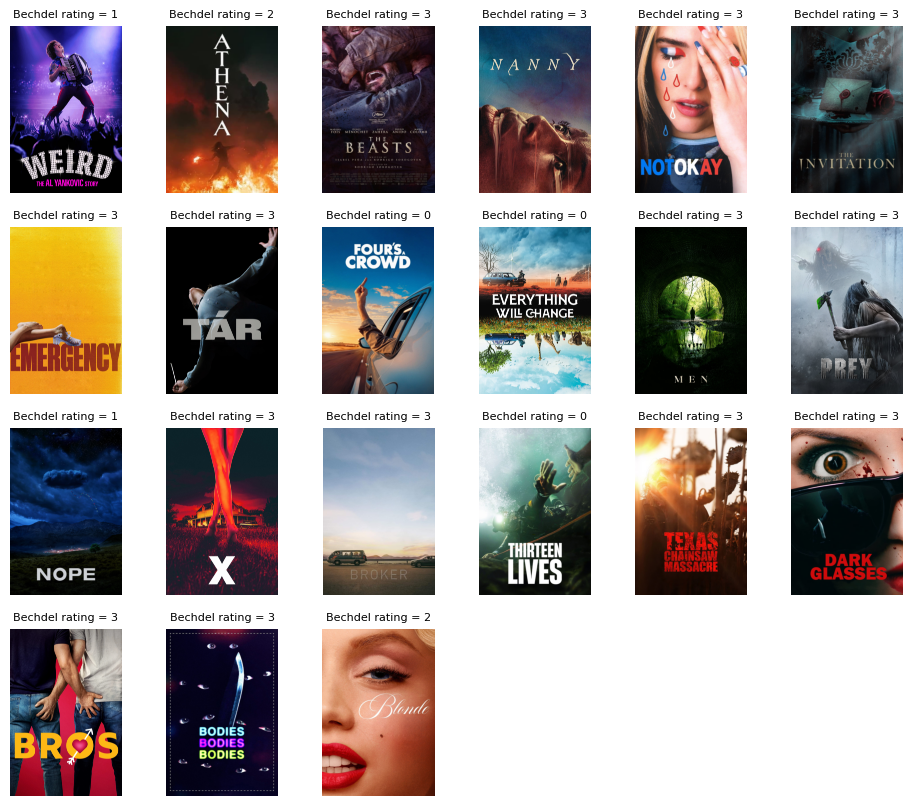

In [138]:
show_posters_with_main_face(metadata_select[metadata_select.isna().any(axis = 1)])

Show all posters

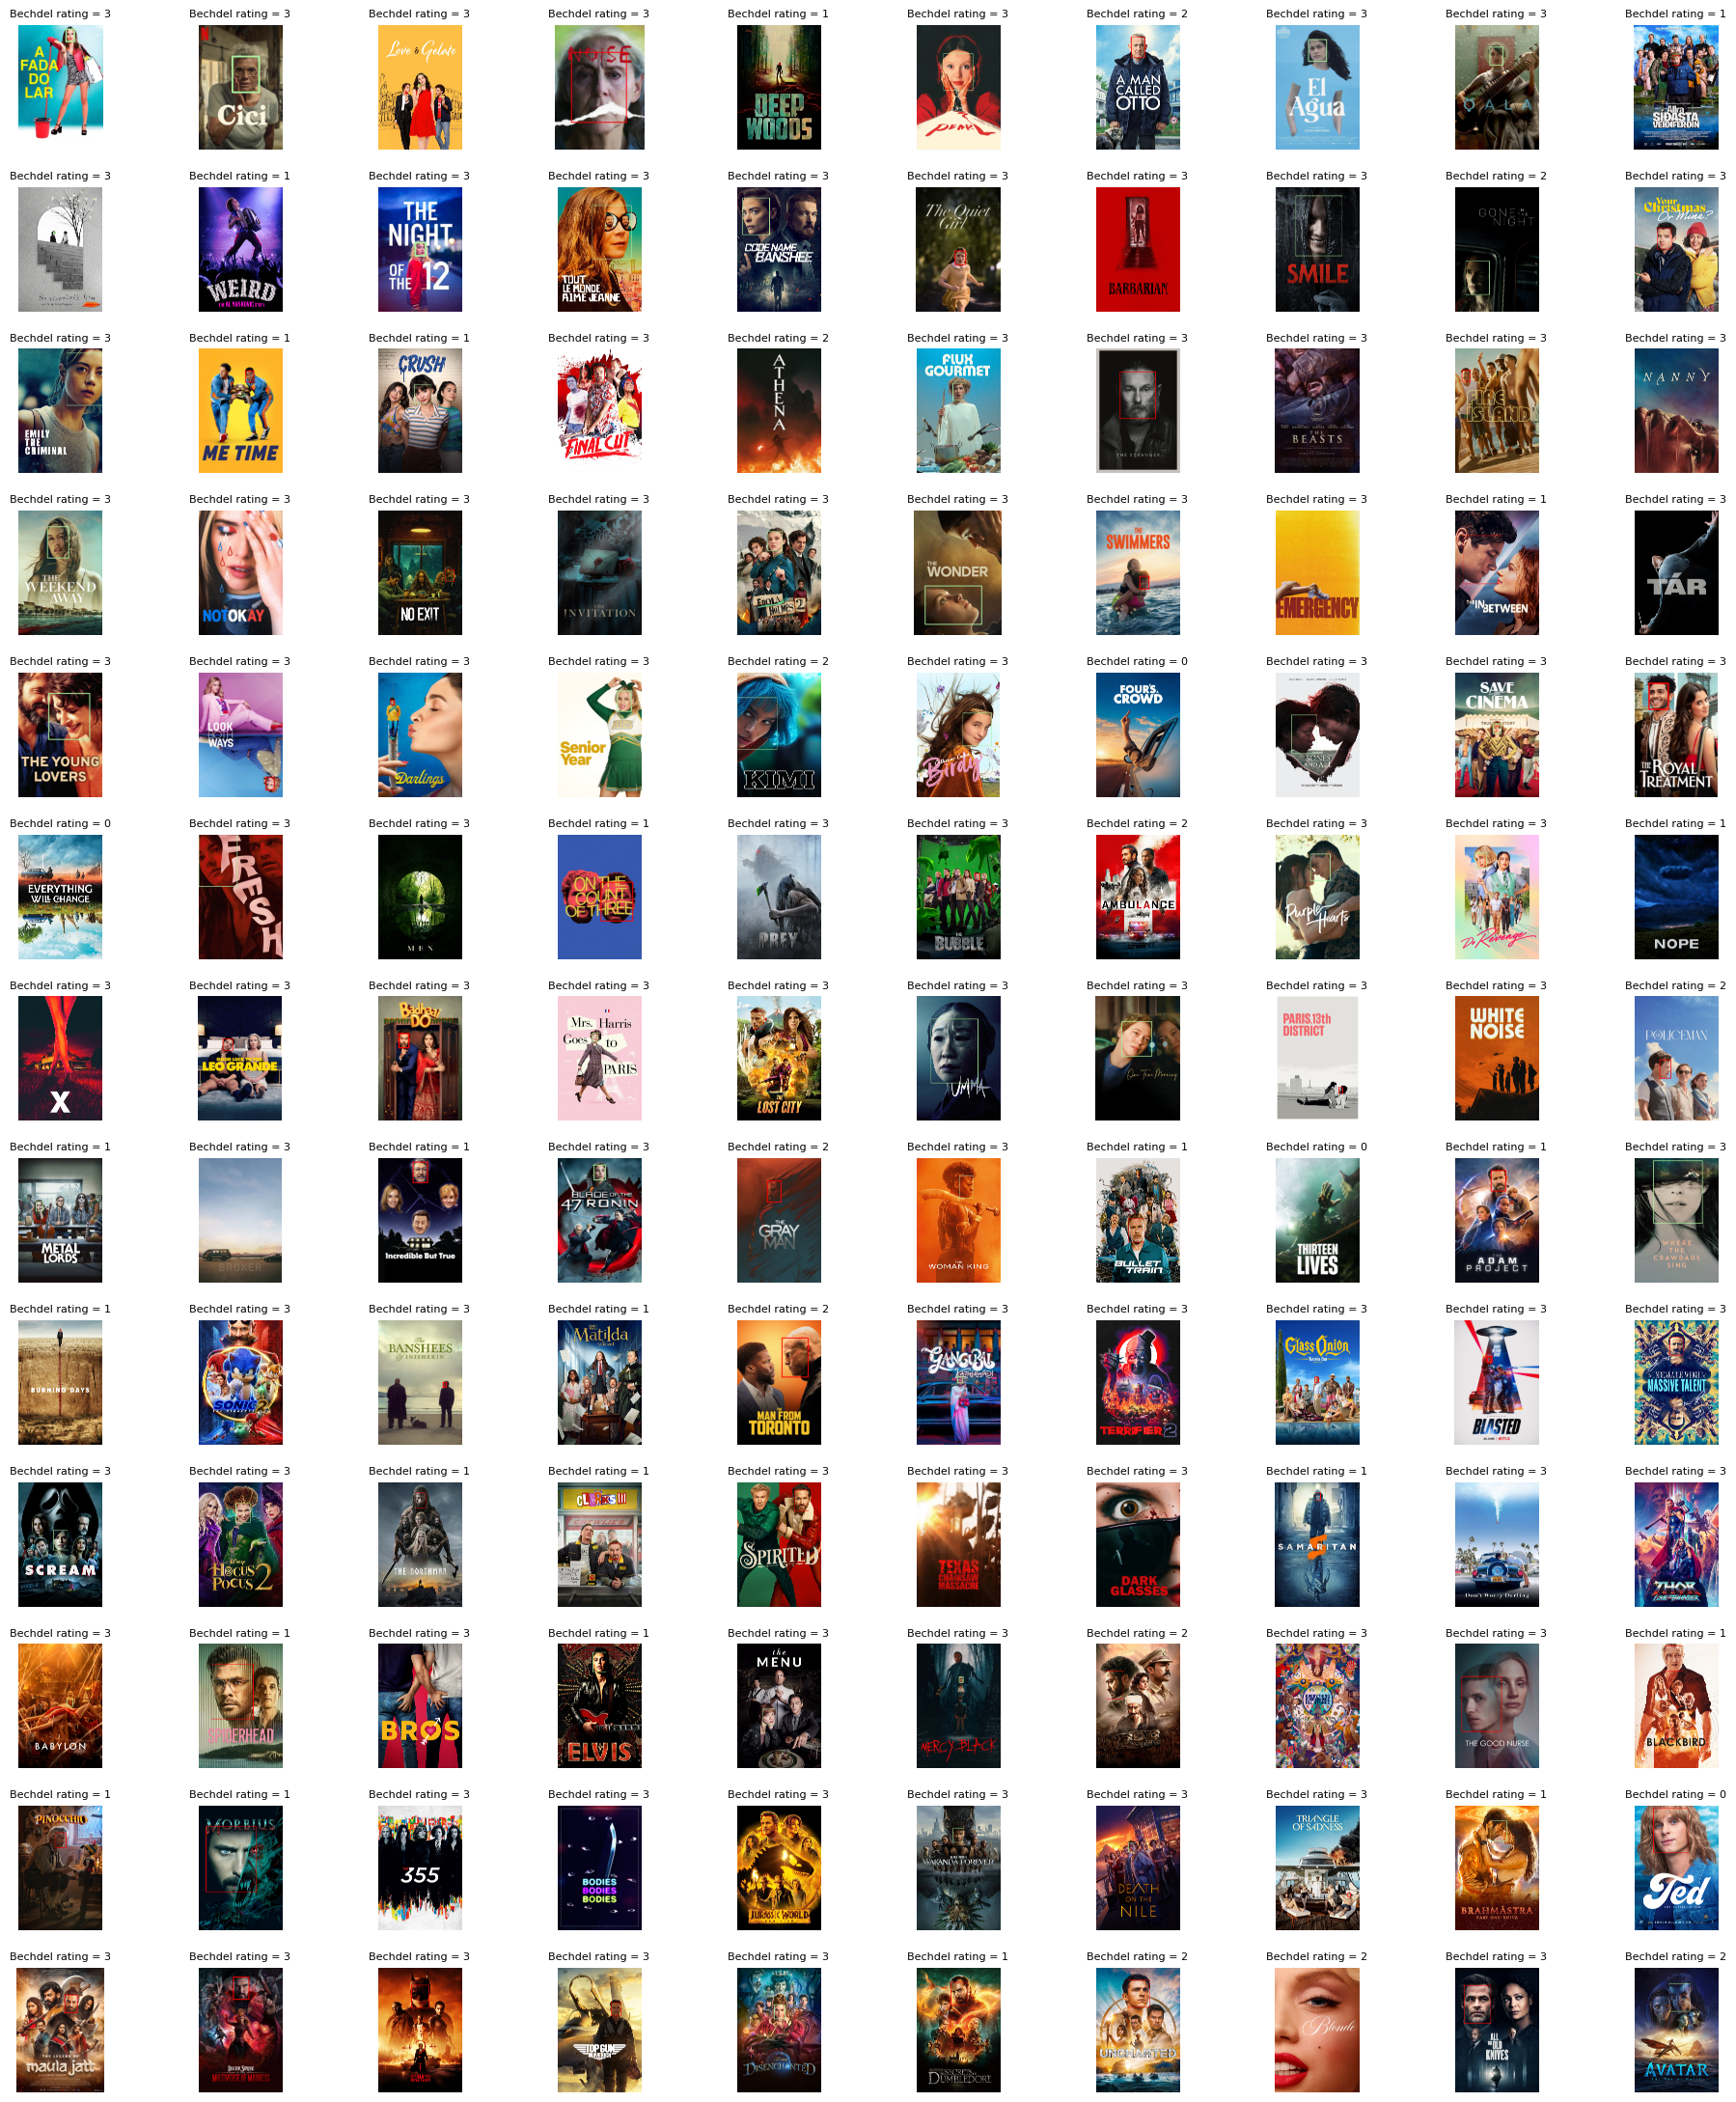

In [162]:
show_posters_with_main_face(metadata_select, figsize = [24, 30], n_cols = 10, wspace = 0.002, hspace = 0.3)

## Study correlations between the Bechdel rating and the gender of the main character on the poster

In [ ]:
metadata_select.info()

In [146]:
data = metadata_select[['bechdel_rating', 'gender']]

# Confusion matrix
cm = pd.crosstab(data['gender'], 
                 data['bechdel_rating'],
                 normalize = 'columns',
                 colnames = ['Bechdel rating'],
                 rownames = ["Main character's gender"],
                 margins = True)

# Re-order the lines in the confusion matrix
cm = cm.reindex(['man', 'woman', 'unknown', 'no face'], axis=0)

# Customize table style
def make_pretty(styler):
    styler.set_caption("Poster analysis of 130 (no animation) movies from bechdeltest.com released in 2022")
    styler.format('{:,.1%}'.format)
    styler.background_gradient(axis=0, vmin=0, vmax=1, cmap="Reds")
    styler.set_properties(**{'width': '80px'})
    return styler



cm.style.pipe(make_pretty)

In [168]:
data = metadata_select[['bechdel_rating', 'gender']]
data['bechdel_rating'] = data['bechdel_rating'].astype('string')

px.histogram(
    data,
    x = "bechdel_rating",
    color = "gender",
    color_discrete_sequence = px.colors.qualitative.Pastel,  #[px.colors.qualitative.Pastel[i] for i in [5, 6]]
    category_orders = {"gender": ['man', 'woman', 'unknown', 'no face'],
                       "bechdel_rating": [0, 1, 2, 3]
                      },
    labels = {"bechdel_rating": "Bechdel rating",
              "gender": "Gender of the main character"
             },
    title = 'Poster analysis of 130 (no animation) movies from bechdeltest.com released in 2022',
    height = 400,
).show()